<a href="https://colab.research.google.com/github/tinghe14/COURSE-2Deep-Learning/blob/main/DeepLearning_Spring2022_HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Deep Learning Homework 6 (Spring 2022)

This code is provided for Deep Learning class (CS 482/682) Homework 6. For ease of implementation, we recommend working entire in Google Colaboratory.

@Copyright Cong Gao, the Johns Hopkins University, cgao11@jhu.edu. Modifications made by Hongtao Wu, Suzanna Sia, Hao Ding, and Keith Harrigian.


### Imports

In [1]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
## Standard Library
import os
import json

## External Libraries
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Variable
import torch.nn.functional as functional
from torch.utils.data import Dataset, DataLoader
from skimage import io
import matplotlib.pyplot as plt

# Problem 1: Unsupervised Pre-training

(a) Train a segmentation network using the frames in the ‘/segmentation/train’ folder.
Please complete the DICE score function to evaluate your model, and write from scratch
a DICE loss function as your network loss (Read more about the DICE score here).
(Hint: You need to convert the grey-scale label mask to one-hot encoding of the label
and then calculate the DICE score for each label). Please train the network until
convergence (should take around 30 min) using the default provided hyperparameters
and provide a figure of training loss and validation loss w.r.t. epochs (in a single figure).
Please report your performance (DICE score) on the test dataset, you should expect a
DICE score > 0.5.

(b) Introduce meaningful data augmentation (e.g. vertical and horizontal flips) and train
the network until convergence using the same hyperparameters as (a). Please plot
the training loss and validation loss on a single figure again and report test dataset
performance, you should expect a DICE score > 0.6.

(c) Train on the colorization task using frames from the ‘/colorization/train_cor’ folder.
Use hyperparameters that seem reasonable (based on your previous experiments) and
mean squared error as your loss function. Please provide a figure of training loss w.r.t.
epochs until your model converges. Then save your model to initialize the network for
the next task.

(d) Load the colorization pre-trained model and start training for the segmentation task
using the frames in the ‘/segmentation/train’ folder. Make sure you are using the
same hyperparameters as you did in the former task, and please clearly state them in
your report. Plot the figure of training loss and validation loss. Report test dataset
performance. Do you see a difference with the former result in (b)?

### Data Paths

In [1]:
# General Data Directory ##TODO: Please fill in the appropriate directory
data_dir = "/content/gdrive/MyDrive/HW6_data"
## Segmentation + Colorization Paths
segmentation_data_dir = f"{data_dir}/segmentation/"
colorization_data_dir = f"{data_dir}/colorization/"

# Mask JSON
mask_json = f"{data_dir}/mapping.json"

### Data Loaders

We have provided you with some preprocessing code for the images but you should feel free to modify the class however you please to support your training schema. In the very least, you will have to modify the dataloader to support loading of the colorization dataset.

In [4]:
## Image Transforms
img_transform = transforms.Compose([ #transforms.ToPILImage()
        transforms.ToTensor(), # a Tensor Image: C*H*W (C #channels)
                               # a batch of Tensor Image: B*C*H*W (B #images in the batch)
            
])

## Image Dataloader
class ImageDataset(Dataset):
    
    """
    ImageDataset
    """
    
    def __init__(self,
                 input_dir,
                 op,
                 mask_json_path,
                 transforms=None):
        """
        ##TODO: Add support for colorization dataset
        
        Args:
            input_dir (str): Path to either colorization or segmentation directory
            op (str): One of "train", "val", or "test" signifying the desired split
            mask_json_path (str): Path to mapping.json file
            transforms (list or None): Image transformations to apply upon loading.
        """
        self.transform = transforms
        self.op = op
        with open(mask_json_path, 'r') as f:
            self.mask = json.load(f)
        self.mask_num = len(self.mask)  # There are 6 categories: grey, dark grey, and black
        #print("len(self.mask)",len(self.mask)) #8
        self.mask_value = [value for value in self.mask.values()]
        self.mask_value.sort()
        #print("self.mask_value", self.mask_value)n #self.mask_value [0, 32, 64, 96, 128, 160, 192, 224]
        try:
            if self.op == 'train':
                self.data_dir = os.path.join(input_dir, 'train')
            elif self.op == 'val':
                self.data_dir = os.path.join(input_dir, 'validation')
            elif self.op == 'test':
                self.data_dir = os.path.join(input_dir, 'test')
        except ValueError:
            print('op should be either train, val or test!')

    def __len__(self):
        """
        
        """
        return len(next(os.walk(self.data_dir))[1])

    def __getitem__(self,
                    idx):
        """
        
        """
        ## Load Image and Parse Properties
        img_name = str(idx) + '_input.jpg'
        mask_name = str(idx) + '_mask.png'
        img = io.imread(os.path.join(self.data_dir, str(idx), img_name))
        mask = io.imread(os.path.join(self.data_dir, str(idx), mask_name))
        #print("len(mask.shape)",len(mask.shape)) #8
        if len(mask.shape) == 2:
            h, w  = mask.shape
        elif len(mask.shape) == 3:
            h, w, c = mask.shape
        ## Convert grey-scale label to one-hot encoding
        new_mask = np.zeros((h, w, self.mask_num))
        #print("new_mask[0,0,1]",new_mask[0]) #0
        for idx in range(self.mask_num):
            #if the mask has 3 dimension use this code
            #new_mask[:, :, idx] = mask[:,:,0] == self.mask_value[idx]
            #if the mask has 1 dimension use the code below
            new_mask[:, :, idx] = mask == self.mask_value[idx]
        #print("new_mask.shape)",new_mask.shape) # (256, 320, 8)
        #print("new_mask[0,0,:])",new_mask[0,0,:]) # [1. 0. 0. 0. 0. 0. 0. 0.]
        ## Transform image and mask
        if self.transform:
            img, mask = self.img_transform(img, new_mask)
        # ## Use dictionary to output
        # sample = {'img': img, 'mask': mask}
        # return sample
        return img, mask

    def img_transform(self,
                      img,
                      mask):
        """
        
        """
        ## Apply Transformations to Image and Mask
        img = self.transform(img)
        mask = self.transform(mask)
        return img, mask

## Model Architecture

Finish building the U-net architecture below.

In [5]:
## Functions for adding the convolution layer
def add_conv_stage(dim_in,
                   dim_out,
                   kernel_size=3,
                   stride=1,
                   padding=1,
                   bias=True,
                   useBN=True):
    """
    
    """
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU()
        )

## Upsampling
def upsample(ch_coarse,
             ch_fine):
    """
    
    """
    return nn.Sequential(
                    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
                    nn.ReLU())
## final layer
def finallayer(input_channel, output_channel):
  return nn.Sequential(
      nn.Conv2d(input_channel, output_channel, kernel_size=3, stride=1, padding=1, bias=True),
      nn.Sigmoid()
  )

# U-Net
class UNET(nn.Module):
    
    """
    
    """
    def __init__(self, useBN=True): # why need n_classes here? 
        """
        Args:
            useBN (bool): Turn Batch Norm on or off
        """
        super(UNET, self).__init__()
        # Downgrade stages
        self.conv1 = add_conv_stage(3, 32, useBN=useBN)
        self.conv2 = add_conv_stage(32, 64, useBN=useBN)
        self.conv3 = add_conv_stage(64, 128, useBN=useBN)
        self.conv4 = add_conv_stage(128, 256, useBN=useBN)
        # Upgrade stages
        self.conv3m = add_conv_stage(256, 128, useBN=useBN)
        self.conv2m = add_conv_stage(128,  64, useBN=useBN)
        self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
        # Maxpool
        self.max_pool = nn.MaxPool2d(2)
        # Upsample layers
        self.upsample43 = upsample(256, 128)
        self.upsample32 = upsample(128,  64)
        self.upsample21 = upsample(64 ,  32)
        # weight initialization
        # You can have your own weight intialization. This is just an example.
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()
        #TODO: Design your last layer & activations
        self.finallayer = finallayer(32,8)


    def forward(self, x):
        """
        Forward pass
        """
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(self.max_pool(conv1_out))
        conv3_out = self.conv3(self.max_pool(conv2_out))
        conv4_out = self.conv4(self.max_pool(conv3_out))

        conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
        conv3m_out  = self.conv3m(conv4m_out_)

        conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
        conv2m_out  = self.conv2m(conv3m_out_)

        conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
        conv1m_out  = self.conv1m(conv2m_out_)

        #TODO: Design your last layer & activations
        convfinalm_out = self.finallayer(conv1m_out)
        return convfinalm_out


In [6]:
print(UNET())

UNET(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=

### DICE Score and DICE Loss

Finish implementing the DICE score function below and then write a Dice Loss function that you can use to update your model weights.

In [33]:
##TODO: Finish implementing the multi-class DICE score function
def dice_score_image(prediction, target, n_classes):
    '''
      computer the mean dice score for a single image

      Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
      Args:
          prediction (tensor): predictied labels of the image
          target (tensor): ground truth of the image
          n_classes (int): number of classes
    
      Returns:
          m_dice (float): Mean dice score over classes
    '''
    ## TODO: Compute Dice Score for Each Class. Compute Mean Dice Score over Classes.
    dice_classes = np.zeros(n_classes)
    # one-hot encoding for prediction
    # output of model: B*C*W*H (B: batch size, C: num of classes) #
    #assert prediction.dim() == 4, "Prediction should be 4 dims"
    predict = nn.functional.one_hot(prediction, num_classes=n_classes).permute(0,3,1,2).contiguous() # output of one_hot: B*H*W*C, permute to obtain: B*C*H*W
    assert predict.dim() == 4, "Output should be 4 dims"
    assert target.dim() == 4, "True label should be 4 dims"
    smooth = 1.
    for cl in range(n_classes):
      # default
      TP, FP, FN = 0, 0, 0
      if target[:,cl,:,:] > 0: 
        TP = torch.sum(1. if (target[:,cl,:,:] == 1 & predict[:,cl,:,:] == 1) else 0)
        FP = torch.sum(1. if (target[:,cl,:,:] == 0 & predict[:,cl,:,:] == 1) else 0)
        FN = torch.sum(1. if (target[:,cl,:,:] == 1 & predict[cl] == 0) else 0)
        dice_classes[cl] = (2*TP + smooth) / (TP+FP+TP+FN + smooth) 
        #When there is no grount truth of the class in this image
        #Give 1 dice score if False Positive pixel number is 0,
        #give 0 dice score if False Positive pixel number is not 0 (> 0).
      else:
        if FP == 0:
          dice_classes[cl] = 1
        else:
          dice_classes[cl] = 0
    return dice_classes.mean()



def dice_score_dataset(model, dataloader, num_classes, use_gpu=True):
    """
    Compute the mean dice score on a set of data.
    
    Note that multiclass dice score can be defined as the mean over classes of binary
    dice score. Dice score is computed per image. Mean dice score over the dataset is the dice
    score averaged across all images.
    
    Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
     
    Args:
        model (UNET class): Your trained model
        dataloader (DataLoader): Dataset for evaluation
        num_classes (int): Number of classes
    
    Returns:
        m_dice (float): Mean dice score over the input dataset
    """
    ## Number of Batches and Cache over Dataset 
    n_batches = len(dataloader)
    scores = np.zeros(n_batches)
    ## Evaluate
    model.eval()
    idx = 0
    for data in dataloader:
        ## Format Data
        img, target = data
        if use_gpu:
            img = img.cuda()
            target = target.cuda()
        ## Make Predictions
        out = model(img)
        n_classes = out.shape[1]
        prediction = torch.argmax(out, dim = 1)
        scores[idx] = dice_score_image(prediction, target, n_classes)
        idx += 1
    ## Average Dice Score Over Images
    m_dice = scores.mean()
    return m_dice


# TODO: Implement DICE loss, 
# It should conform to how we computer the dice score.
class DICELoss(nn.Module):
    def __init__(self):
      super(DICELoss, self).__init__()
      
    def forward(self, pred, target):
      # pred: (B C H W)
      # target: (B C H W), one-hot already
      smooth = 1
      batch_size = target.shape[0]
      n_classes = target.shape[1]
      #pred_flat = pred.view(batch_size, n_classes, -1)
      #target_flat = target.view(batch_size, n_classes, -1)
      #dice_score = (2 * (pred_flat * target_flat).sum(axis=-1) + smooth) / ((pred_flat*pred_flat).sum(axis=-1) + (target_flat*target_flat).sum(axis=-1) + smooth) # flat
      pred_flat = pred.view(-1)
      target_flat = target.view(-1)
      intersection = (pred_flat * target_flat).sum()
      A_sum = torch.sum(pred_flat*pred_flat)
      B_sum = torch.sum(target_flat*target_flat)
      dice_score = (2*intersection+smooth) / (A_sum+B_sum+smooth)
      #dice_score = (2*intersection+smooth) / ((pred_flat+target_flat).sum()+smooth)
      loss = 1 - dice_score
      return loss


### Training Hyperparameters

These are recommended hyperparameters - please feel free to use what works for you. Batch size can be changed if it does not match your memory, please state your batch step_size in your report.

In [8]:
## Batch Size
train_batch_size = 32 #20->128
validation_batch_size = 10

## Learning Rate
learning_rate = 0.0001

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 50 # original 200

## Training Procedure (Segmentation)

In [9]:
import time

In [10]:
## Initialize your unet
n_classes = 8
model = UNET()
#criterion = DICELoss()

## Initialize Dataloaders
train_dataset=ImageDataset(input_dir=segmentation_data_dir, op="train", mask_json_path=mask_json, transforms=img_transform)
validation_dataset=ImageDataset(input_dir=segmentation_data_dir, op="val", mask_json_path=mask_json, transforms=img_transform)
test_dataset=ImageDataset(input_dir=segmentation_data_dir, op="test", mask_json_path=mask_json, transforms=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
## Initialize Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) #every 10 epochs, update learning rate *0.1


In [11]:
# test the dimensions
for i, (images, labels) in enumerate(train_dataloader):
  print("images.shape",images.shape)
  print("labels.shape",labels.shape)
  #print("gray scale of label",labels[0])
  outputs = model(images)
  print("output.shape",outputs.shape)
  break

torch.cuda.empty_cache() # clean the cache

images.shape torch.Size([10, 3, 256, 320])
labels.shape torch.Size([10, 8, 256, 320])
output.shape torch.Size([10, 8, 256, 320])


In [12]:
def train(model,
          optimizer,
          criterion,
          scheduler,
          num_epochs = 10,
          train_dataloader = train_dataloader,
          validation_dataloader = validation_dataloader,
          test_dataloader = test_dataloader,
          **kwargs):
  

  start = time.time()
  print("Start Training...")
  device = torch.device("cuda")
  torch.cuda.empty_cache() # clean the cache
  model.to(device) # model, dataset, computing all put into device (gpu here)
  train_loss_history, val_loss_history = [], [] #pixel-wise segmentation so don't have things like correct case like before
  for epoch in range(num_epochs):
      ########################### Training #####################################
      model.train() # clarify this is training process
      train_total_loss, train_total_count = 0., 0 
      print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
      # TODO: Design your own training section
      for i, (train_images, true_labels) in enumerate(train_dataloader): #batch_size
        optimizer.zero_grad() # clear to 0 after one backpropagation
        outputs = model(train_images.to(device))
        train_loss = criterion(outputs, true_labels.to(device)) # averge loss 
        train_total_loss += train_loss.item() * outputs.size(0) #item() will also move to cpu # same as shape(0) which is batch size (final batch size might be less)
        train_total_count += outputs.size(0) # outputs.size(0) is a batch size we need to count all
        train_loss.backward()
        optimizer.step()
      
      train_loss_history.append(train_total_loss / train_total_count)
      scheduler.step() # every epoch updates its learning rate

      ########################### Validation #####################################
      # TODO: Design your own validation section
      # chose hyperparameter based on our valloss here
      with torch.no_grad():
        val_total_loss, val_total_count = 0., 0
        for i, (val_images, true_labels) in enumerate(validation_dataloader):
          outputs = model(val_images.to(device))
          val_loss = criterion(outputs, true_labels.to(device))
          val_total_loss += val_loss.item() * outputs.size(0)
          val_total_count += outputs.size(0)
      
      val_loss_history.append(val_total_loss / val_total_count)
      print('Epoch: {}. TrainLoss: {}. ValLoss: {}.'.format(
            epoch+1, train_loss_history[-1], val_loss_history[-1]))

  period = time.time() - start 
  print ('Time finished in {:.0f}m {:.0f}s'.format(period // 60, period % 60)) 
  return train_loss_history, val_loss_history        

In [21]:
torch.cuda.empty_cache()

In [22]:
out = train(model=UNET(),
      optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate),
      criterion=DICELoss(), 
      scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1),
      num_epochs=100,
      train_dataloader=train_dataloader,
      validation_dataloader=validation_dataloader,
      test_dataloader=test_dataloader)

Start Training...

EPOCH 1 of 100



/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch: 1. TrainLoss: 0.6584456945035808. ValLoss: 0.6581370535740342.

EPOCH 2 of 100

Epoch: 2. TrainLoss: 0.6584826240412974. ValLoss: 0.6581370524869405.

EPOCH 3 of 100

Epoch: 3. TrainLoss: 0.658457027349066. ValLoss: 0.6581370521964268.

EPOCH 4 of 100

Epoch: 4. TrainLoss: 0.6584643299253723. ValLoss: 0.6581370532705472.

EPOCH 5 of 100

Epoch: 5. TrainLoss: 0.6584263706151163. ValLoss: 0.6581370533997111.

EPOCH 6 of 100

Epoch: 6. TrainLoss: 0.6584265000135952. ValLoss: 0.6581370534821822.

EPOCH 7 of 100

Epoch: 7. TrainLoss: 0.6584789993388931. ValLoss: 0.6581370533790434.

EPOCH 8 of 100

Epoch: 8. TrainLoss: 0.6584403299707556. ValLoss: 0.6581370531671888.

EPOCH 9 of 100

Epoch: 9. TrainLoss: 0.6584529900619664. ValLoss: 0.6581370530055528.

EPOCH 10 of 100

Epoch: 10. TrainLoss: 0.6584548778746956. ValLoss: 0.6581370536244081.

EPOCH 11 of 100

Epoch: 11. TrainLoss: 0.6584429596053631. ValLoss: 0.6581370533839465.

EPOCH 12 of 100

Epoch: 12. TrainLoss: 0.658467217729507

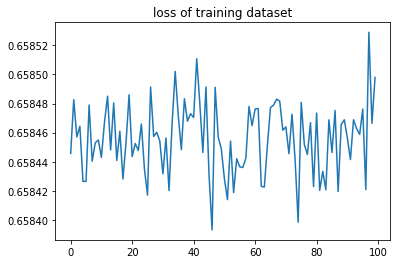

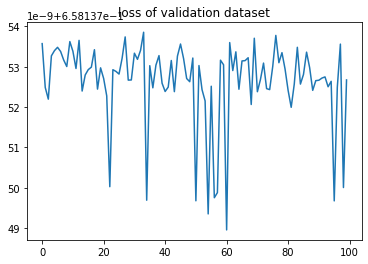

In [23]:
plt.plot(range(100), out[0])
plt.title("loss of training dataset")
plt.show()
plt.plot(range(100), out[1]) 
plt.title("loss of validation dataset")
plt.show()

In [40]:
########################### Test ##################################### 

#device = torch.device("cuda")
criterion = DICELoss()
    
test_loss_history = []
test_total_loss = 0.
test_total_count  = 0

for i, (test_images, true_labels) in enumerate(test_dataloader):
  outputs = model(test_images)
  test_loss = criterion(outputs, true_labels)
  test_total_loss += test_loss.item() * outputs.size(0)
  test_total_count += outputs.size(0)
    
test_loss_history.append(test_total_loss / test_total_count)
print("Test Loss: {}".format(test_loss_history[-1]))
print("Test Score: {}".format(1- test_loss_history[-1]))


Test Loss: 0.6643227287464274
Test Score: 0.3356772712535726


## Data Augmentation

### Data Loader

In [ ]:
## Image Transforms
img_transform = transforms.Compose([ #transforms.ToPILImage()
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
])

In [ ]:
## Visualize few pics
def visual_test(model, num_row, num_col):
  fig, axs = plt.subplots(num_row, num_col,figsize=(21,4))
  #num_batch = np.ceil(num_row * num_col / test_batch_size)
  #images, pred_labels, true_labels = [], [], []
  # test stage
  #with torch.no_grad():
  for i, (imgs, labs) in enumerate(train_dataloader):
      if i >= num_batch:
        break
      else:
        imgs = imgs.to(device)
        labs = labs.to(device)
        outputs = model(imgs)
        _, pred = torch.max(outputs, 1)
        if len(images) == 0:
          images = imgs.cpu().numpy()
        else:
          images = np.concatenate([images, imgs.cpu().numpy()], axis=0) 
        pred_labels.extend(pred.cpu().numpy())
        true_labels.extend(labs.cpu().numpy())
  # print("images.shape", images.shape)
  # print("pred_labels", len(pred_labels))
  # print("true_labels", len(true_labels))  
  for i in range(num_row):
    for j in range(num_col):
      axs[i][j].axis("off")
      axs[i][j].set_title(f"predicted: {pred_labels[i*num_col+j]}, true: {true_labels[i*num_col+j]}")
      axs[i][j].imshow(images[i*num_col+j][0])

## Training Procedure: Colorization Pre-training

Complete the rest of this problem in the cells below.

# Problem 2: Transfer Learning

### Imports

In [ ]:
## Import VGG and FashionMNIST
from torchvision.models import vgg16
from torchvision.datasets import FashionMNIST

### Data Loading

In [ ]:
## Specify Batch Size
train_batch_size = 128 #32->128 more sample move to gpu once, which result running much faster
test_batch_size = 32

## Specify Image Transforms
img_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

## Download Datasets
train_data = FashionMNIST('./data', transform=img_transform, download=True, train=True)
test_data = FashionMNIST('./data', transform=img_transform, download=True, train=False)

## Initialize Dataloaders
train_dataloader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=test_batch_size, shuffle=True)

In [ ]:
# test the dimensions

for i, (images, labels) in enumerate(train_dataloader):
  print("images.shape",images.shape)
  print("labels.shape",labels.shape)
  #print("gray scale of label",labels[0])
  break


images.shape torch.Size([128, 1, 64, 64])
labels.shape torch.Size([128])


### Model Initialization and Training/Fine-tuning

Complete the rest of the assignment in the notebook below.

(a) Randomly initialize all parameters in VGG16 and try to train your model to learn the
Fashion MNIST classification task. What’s the accuracy you achieve? Please report
your test accuracy on the test dataset. You should expect an accuracy > 85%

In [ ]:
device = torch.device("cuda")

In [ ]:
import time
import matplotlib.pyplot as plt 

In [ ]:
def train(model,
          optimizer,
          criterion,
          lr,
          epochs=15,
          train_dataloader=train_dataloader,
          test_dataloader=test_dataloader,
          device=device,
          **kwargs):
    """
    
    """
    start = time.time()
    model.to(device)
    loss_history, train_acc_history = [], []
    ##TODO: Implement a training loop
    for epoch in range(epochs):
      model.train()
      total_loss, n_count, correct = 0., 0, 0
      for i, (images, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(images.to(device))
        loss = criterion(outputs, labels.to(device))
        total_loss += loss.item() * outputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted.cpu() == labels.cpu()).sum() 
        n_count += outputs.size(0)
        loss.backward()
        optimizer.step()

      loss_history.append(total_loss / n_count)
      train_acc_history.append(correct / n_count)

      
      print('Epoch: {}. TrainLoss: {}. TrainAcc: {}. '.format(
          epoch+1, loss_history[-1], train_acc_history[-1]
        ))
    
    period = time.time() - start 
    print ('Training time finished in {:.0f}m {:.0f}s'.format(period // 60, period % 60))
    
    with torch.no_grad():
      n_count, correct = 0, 0
      for i, (images, labels) in enumerate(test_dataloader):
        #outputs = model(images)
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1) # why 1
        correct += (predicted.cpu() == labels.cpu()).sum() 
        n_count += outputs.size(0)
    test_acc = correct / n_count
    print("Test Acc: {}".format(test_acc))
        
    return loss_history, train_acc_history, test_acc
                

In [ ]:
## Visualize test image

def visual_test(model, num_row, num_col):
  fig, axs = plt.subplots(num_row, num_col,figsize=(21,4))
  num_batch = np.ceil(num_row * num_col / test_batch_size)
  images, pred_labels, true_labels = [], [], []
  # test stage
  with torch.no_grad():
    for i, (imgs, labs) in enumerate(test_dataloader):
      if i >= num_batch:
        break
      else:
        imgs = imgs.to(device)
        labs = labs.to(device)
        outputs = model(imgs)
        _, pred = torch.max(outputs, 1)
        if len(images) == 0:
          images = imgs.cpu().numpy()
        else:
          images = np.concatenate([images, imgs.cpu().numpy()], axis=0) 
        pred_labels.extend(pred.cpu().numpy())
        true_labels.extend(labs.cpu().numpy())
  # print("images.shape", images.shape)
  # print("pred_labels", len(pred_labels))
  # print("true_labels", len(true_labels))  
  for i in range(num_row):
    for j in range(num_col):
      axs[i][j].axis("off")
      axs[i][j].set_title(f"predicted: {pred_labels[i*num_col+j]}, true: {true_labels[i*num_col+j]}")
      axs[i][j].imshow(images[i*num_col+j][0])

In [ ]:
## Hyperparameters
num_epochs = 10
LR = 0.001##TODO: Choose a Learning Rate

## Setting up the model, optimizer, and loss function
# construct a vgg16 model with random weights by calling its constructor
model_2a = vgg16()
# modify input channel into 1
model_2a.features[0] = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
# modify later layer into 10 
model_2a.classifier[-1] = nn.Linear(in_features=4096, out_features=10)
print(model_2a)
optimizer = torch.optim.Adam(model_2a.parameters(),lr=LR)##TODO: Choose an optimized
loss_f = nn.CrossEntropyLoss(reduction='mean') ##TODO: Choose a loss

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
## Run Training Loop
print("Start Training...")
out = train(model_2a, optimizer, loss_f, LR, num_epochs)

Start Training...
Epoch: 1. TrainLoss: 2.0758621888955435. TrainAcc: 0.7173500061035156. 
Epoch: 2. TrainLoss: 0.3503951020717621. TrainAcc: 0.8736166954040527. 
Epoch: 3. TrainLoss: 0.2954966155370076. TrainAcc: 0.893916666507721. 
Epoch: 4. TrainLoss: 0.2610520069917043. TrainAcc: 0.9073833227157593. 
Epoch: 5. TrainLoss: 0.2392923238436381. TrainAcc: 0.9155499935150146. 
Epoch: 6. TrainLoss: 0.2233657407919566. TrainAcc: 0.9206500053405762. 
Epoch: 7. TrainLoss: 0.2166647048632304. TrainAcc: 0.9242166876792908. 
Epoch: 8. TrainLoss: 0.20797237927913667. TrainAcc: 0.9255833625793457. 
Epoch: 9. TrainLoss: 0.1994505046447118. TrainAcc: 0.9301000237464905. 
Epoch: 10. TrainLoss: 0.1877671267271042. TrainAcc: 0.9349499940872192. 
Training time finished in 12m 18s
Test Acc: 0.9142000079154968


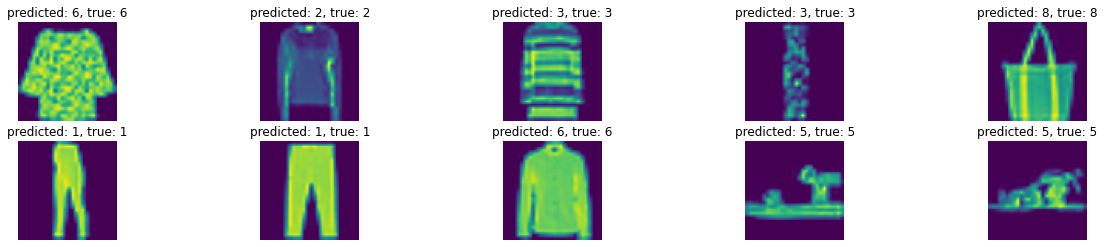

In [ ]:
visual_test(model_2a, 2,5)

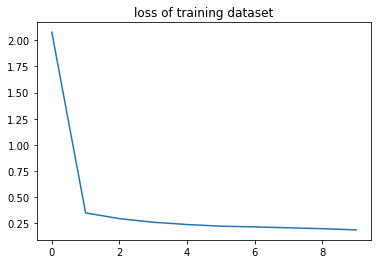

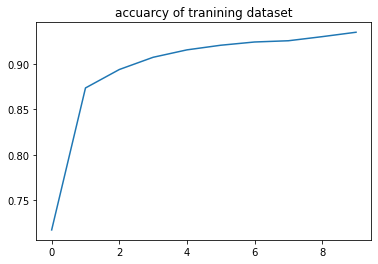

In [ ]:
plt.plot(range(10), out[0])
plt.title("loss of training dataset")
plt.show()
plt.plot(range(10), out[1]) 
plt.title("accuarcy of tranining dataset")
plt.show()

(b) Load the pre-trained VGG16 model from torch vision models. Freeze all but the last
layer: randomly initialize the last layer of your network and fine-tune this. What
accuracy do you get now? Please again report your test accuracy on the test dataset.
You should expect an accuracy > 60%.

In [ ]:
## Setting up the model, optimizer, and loss function
# construct a vgg16 model with random weights by calling its constructor
model_2b = vgg16(pretrained=True)
# freeze all network except the final layer
for param in model_2b.parameters():
  param.requires_grad = False

# parameters of newly constructed modules hve requires_grad=True by default
# modify input channel into 1
model_2b.features[0] = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
# modify last layer into 10 
model_2b.classifier[-1] = nn.Linear(in_features=4096, out_features=10)

print(model_2b)
optimizer = torch.optim.Adam(model_2b.parameters(),lr=LR)##TODO: Choose an optimized
loss_f = nn.CrossEntropyLoss(reduction='mean') ##TODO: Choose a loss

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
## Run Training Loop
print("Start Training...")
out = train(model_2b, optimizer, loss_f, LR, num_epochs)

Start Training...
Epoch: 1. TrainLoss: 0.7919221584002177. TrainAcc: 0.7178833484649658. 
Epoch: 2. TrainLoss: 0.6014206363360087. TrainAcc: 0.7837166786193848. 
Epoch: 3. TrainLoss: 0.554965943145752. TrainAcc: 0.7993500232696533. 
Epoch: 4. TrainLoss: 0.5296242933909099. TrainAcc: 0.8070666790008545. 
Epoch: 5. TrainLoss: 0.520281258392334. TrainAcc: 0.8119833469390869. 
Epoch: 6. TrainLoss: 0.5053430538495381. TrainAcc: 0.8162999749183655. 
Epoch: 7. TrainLoss: 0.4877730200767517. TrainAcc: 0.8218333125114441. 
Epoch: 8. TrainLoss: 0.48569672827720645. TrainAcc: 0.8242499828338623. 
Epoch: 9. TrainLoss: 0.48570092336336773. TrainAcc: 0.824733316898346. 
Epoch: 10. TrainLoss: 0.478108192952474. TrainAcc: 0.8261833190917969. 
Training time finished in 7m 26s
Test Acc: 0.819100022315979


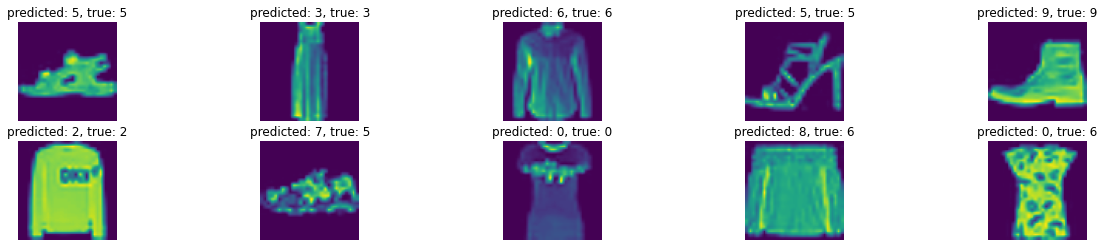

In [ ]:
visual_test(model_2b, 2,5)

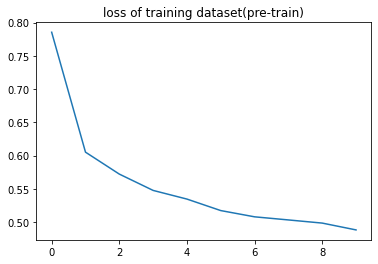

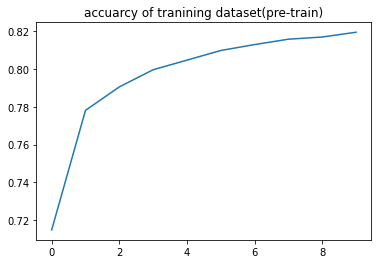

In [ ]:
plt.plot(range(10), out[0])
plt.title("loss of training dataset(pre-train)")
plt.show()
plt.plot(range(10), out[1]) 
plt.title("accuarcy of tranining dataset(pre-train)")
plt.show()

(c) Now, imagine a scenario in which you want to train the VGG16 model on an entirely
new dataset and will fine-tune either the model from (2a) or (2b). Which pre-trained
model is the preferred starting point for your new use case?

**Answer** The following ideas were learned from 'Transfer Learning' in Stanford CS231N and summarized with own words. Link: https://cs231n.github.io/transfer-learning/.
These two exercises we did are belong to transfer learning methods. The first one is to use pre-trained model as initial framework and fine tuning the weights of pre-trained model by backpropagation, while the second one is to use pre-trained model as fixed feature extractor with only tuning a small part of weights in the final few layers. When having new use case, we can decide to use which methods by considering following items. 1) size of new data, 2) similarity between new data and original data. When the new dataset is small and similar with original dataset, we prefer to fine tuning the last few layers to avoid the overfitting problem. When the new dataset is large and similar with original one, we can fine-tune through the full network since we have more confidence it won't cause the overfitting problem. If the new dataset is small and different than original one, I believe the better way is to train own model without transfer learning. The last case is we have a large dataset and it is different than original one, we can try to fine-tune the pretrain model from scratch but might also be a not good idea for trying transfer learning.